In [133]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm, mannwhitneyu
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

## Загрузка данных

In [31]:
df = pd.read_csv('cian.csv', encoding='Windows-1251', sep = ';', usecols = [k for k in range(1,9)] )

In [32]:
df.isna().sum()

Компания                  0
Категория                 0
Регион                    0
Тип сделки                0
Категория недвижимости    0
Рубрика                   0
Неделя                    0
Контент                   0
dtype: int64

In [33]:
df.dtypes

Компания                  object
Категория                 object
Регион                    object
Тип сделки                object
Категория недвижимости    object
Рубрика                   object
Неделя                    object
Контент                    int64
dtype: object

In [34]:
df.describe(include = 'object')

,Компания,Категория,Регион,Тип сделки,Категория недвижимости,Рубрика,Неделя
count,104412,104412,104412,104412,104412,104412,104412
unique,2,7,16,2,2,3,98
top,Игрок 2,Собственник (1),Краснодар,Аренда,Городская,Вторичка,С 2018-06-04 до 2018-06-10
freq,54110,17753,7569,63142,55466,41270,1094


In [35]:
df = df.join(df['Неделя'].str.replace('С ', '').str.split(' до ', expand = True).rename(columns = {0:'start', 1:'end'}))
df.drop(columns = 'Неделя', inplace = True)
df.rename(columns = {'Компания':'Company',
                     'Категория':'Client',
                     'Регион':'Region',
                     'Тип сделки':'Deal_type',
                     'Категория недвижимости':'Estate_type',
                     'Рубрика':'Rubric',
                     'Контент':'Content'}, inplace = True )

In [36]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

In [37]:
df

,Company,Client,Region,Deal_type,Estate_type,Rubric,Content,start,end
0,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,69,2018-01-01,2018-01-07
1,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,63,2018-01-08,2018-01-14
2,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,81,2018-01-15,2018-01-21
3,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,86,2018-01-22,2018-01-28
4,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,86,2018-01-29,2018-02-04
...,...,...,...,...,...,...,...,...,...
104407,Игрок 2,Частный маклер (2-3),Воронеж,Продажа,Загородная,Вторичка,283,2019-10-21,2019-10-27
104408,Игрок 2,Частный маклер (2-3),Воронеж,Продажа,Загородная,Вторичка,282,2019-10-28,2019-11-03
104409,Игрок 2,Частный маклер (2-3),Воронеж,Продажа,Загородная,Вторичка,279,2019-11-04,2019-11-10
104410,Игрок 2,Частный маклер (2-3),Воронеж,Продажа,Загородная,Вторичка,284,2019-11-11,2019-11-17


In [38]:
df.isna().sum()

Company        0
Client         0
Region         0
Deal_type      0
Estate_type    0
Rubric         0
Content        0
start          0
end            0
dtype: int64

In [39]:
cat = pd.read_csv('cat.csv', encoding='Windows-1251', sep = ';')
cat

,Category,Segment
0,Большое агенство (201-1000),АН
1,Крупное агенство (1000+),АН
2,Крупный маклер (4-9),SMB
3,Малое агенство (10-50),SMB
4,Собственник (1),Owner
5,Среднее агенство (51-200),АН
6,Частный маклер (2-3),SMB


In [40]:
df = df.merge(cat, left_on = 'Client', right_on = 'Category').drop(columns = 'Category')
df.head(3)

,Company,Client,Region,Deal_type,Estate_type,Rubric,Content,start,end,Segment
0,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,69,2018-01-01,2018-01-07,АН
1,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,63,2018-01-08,2018-01-14,АН
2,Игрок 1,Большое агенство (201-1000),Челябинск,Аренда,Городская,Долгосрочная,81,2018-01-15,2018-01-21,АН


In [41]:
#df.to_excel('cian_prepared.xlsx')

In [42]:
# Количество сделок по неделям
df1 = df.groupby(['Company','start'], as_index = False).agg({'Content':'count'}).rename(columns = {'Content':'Deals_number'})
df1.head(3)

,Company,start,Deals_number
0,Игрок 1,2018-01-01,536
1,Игрок 1,2018-01-08,555
2,Игрок 1,2018-01-15,539


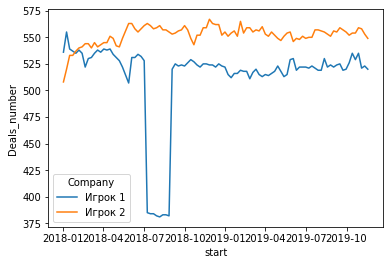

In [43]:
sns.lineplot(data = df1,
            x = 'start',
            y = 'Deals_number',
            hue = 'Company')

In [44]:
# Период провала в данных для игрока 1
df1.query('Deals_number < 400').sort_values('start')

,Company,start,Deals_number
26,Игрок 1,2018-07-09,385
27,Игрок 1,2018-07-16,384
28,Игрок 1,2018-07-23,384
29,Игрок 1,2018-07-30,382
30,Игрок 1,2018-08-06,381
31,Игрок 1,2018-08-13,383
32,Игрок 1,2018-08-20,383
33,Игрок 1,2018-08-27,382


Возможно, на неделях, начинавшизся 9 июля по 27 августа, у игрока №2 происходили сбои с записью информации. Необходимо проверить, действительно ли были сбои. Для дальнейшего анализа отбросим 

## Расчет среднего количество сделок на регион и очистка датасета

In [45]:
# Подсчет количество сделок в неделю для игроков во всех сегментах (тип сделки, тип жилья, длительность аренды, регион, тип клиента)
df_count = df \
        .groupby(['Company', 'Deal_type','Estate_type','Rubric', 'Segment','Region','start'], as_index = False) \
        .agg({'end':'count'}) \
        .rename(columns = {'end':'deals_num'})

In [46]:
# Подсчет стандартного отклонения между недельными средними количествами сделок на регион во всех сегментах
#(тип сделки, тип жилья, длительность аренды, регион, тип клиента)

df_std = df_count \
    .groupby(['Company', 'Deal_type','Estate_type','Rubric', 'Segment','Region'], as_index = False) \
    .agg({'deals_num':'std'}) \
    .rename(columns = {'deals_num':'deals_std'})

df_std.query('deals_std<= 0.11').deals_std.unique()

array([0.        , 0.10101525, 0.10101525, 0.10101525])

Стандартное отклонение средних количеств сделок по региону, равное нулю означает, что каждую неделю в игрок вносил в базу одно и то же количество сделок в сегменте. То, что количество сделок было одинаково каждую неделю на протяжении почти двух лет, выглядит маловероятным. Поэтому мы отбросим данные для таких регионов и сегментов. Таже отбросим данные с SD < 0.11 - для таких регионов в сегменте Игрок внес только одно отличающееся от остальных значение

In [47]:
df_count = df_count \
        .merge(df_std, on = ['Company', 'Deal_type','Estate_type','Rubric', 'Segment','Region'])

In [48]:
len(df_count.query('deals_std > 0.11'))

14221

In [49]:
# Агрегируем данные в сегментах:
# в каждую неделю в каждом сегменте сложим количество всех сделок во всех регионах для каждого игрока
# и поделим на количество регионов

# Тажке запишем количество количество регионов, в которых были проведены сделки в эту неделю для каждого игрока (ок регионы)

deals_per_reg = df_count.query('deals_std > 0.11') \
    .groupby(['Company', 'Deal_type','Estate_type','Rubric', 'Segment', 'start'], as_index = False) \
    .agg({'deals_num':'mean', 'Region':'nunique'}) \
    .rename(columns = {'deals_num':'avg_deals_per_region', 'Region':'ok_regions_num'})

In [50]:
# Тажке запишем количество количество регионов, в которых были проведены сделки в эту неделю для каждого игрока
# в полном датасете (все регионы)

tot_deals_per_reg = df_count \
    .groupby(['Company', 'Deal_type','Estate_type','Rubric', 'Segment', 'start'], as_index = False) \
    .agg({'deals_num':'mean', 'Region':'nunique'}) \
    .rename(columns = {'deals_num':'tot_deals_per_region', 'Region':'tot_regions_num'})

In [51]:
deals_per_reg = deals_per_reg \
    .merge(tot_deals_per_reg.drop(columns = 'tot_deals_per_region'),
           on = ['Company', 'Deal_type','Estate_type','Rubric', 'Segment', 'start'])

In [52]:
# Для анализа отбросим сегмент, в котором были представлены результаты лишь для одного игрока

qr = '(Company !="Игрок 2")|(Segment != "SMB")|(Estate_type != "Городская")|(Deal_type != "Аренда")|(Rubric != "Посуточная")'

deals_per_reg.query(qr)

,Company,Deal_type,Estate_type,Rubric,Segment,start,avg_deals_per_region,ok_regions_num,tot_regions_num
0,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-01,2.444444,9,15
1,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-08,2.888889,9,15
2,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-15,2.444444,9,15
3,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-22,2.333333,9,15
4,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-29,2.222222,9,15
...,...,...,...,...,...,...,...,...,...
1637,Игрок 2,Продажа,Загородная,Вторичка,АН,2019-10-21,2.750000,8,16
1638,Игрок 2,Продажа,Загородная,Вторичка,АН,2019-10-28,2.875000,8,16
1639,Игрок 2,Продажа,Загородная,Вторичка,АН,2019-11-04,2.875000,8,16
1640,Игрок 2,Продажа,Загородная,Вторичка,АН,2019-11-11,2.750000,8,16


In [53]:
# Финальный датасет
fin = deals_per_reg.query(qr)

In [54]:
#fin.to_excel('deals_per_reg_pairs.xlsx')

## Статистический анализ

### Суммарное количество сделок по аренде и продажам

In [152]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = min([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        loc = 0, 
        x = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        loc = 0, 
        x = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

In [75]:
fin.head()

,Company,Deal_type,Estate_type,Rubric,Segment,start,avg_deals_per_region,ok_regions_num,tot_regions_num
0,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-01,2.444444,9,15
1,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-08,2.888889,9,15
2,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-15,2.444444,9,15
3,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-22,2.333333,9,15
4,Игрок 1,Аренда,Городская,Долгосрочная,АН,2018-01-29,2.222222,9,15


In [147]:
rent = fin.query('Deal_type == "Аренда"')[['avg_deals_per_region', 'Company']].pivot(columns = 'Company', values = 'avg_deals_per_region')
rent

sales = fin.query('Deal_type == "Продажа"')[['avg_deals_per_region', 'Company']].pivot(columns = 'Company', values = 'avg_deals_per_region')
sales

Company,Игрок 1,Игрок 2
564,2.500,NaN
565,3.000,NaN
566,2.625,NaN
567,2.625,NaN
568,2.625,NaN
...,...,...
1637,NaN,2.750
1638,NaN,2.875
1639,NaN,2.875
1640,NaN,2.750


In [76]:
segments = ['Company', 'Deal_type']

totals = fin.groupby(segments, as_index = False).agg({'avg_deals_per_region':list})

### Среднее количество сделок аренды

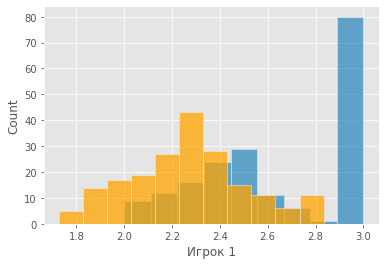

In [190]:
sns.histplot(rent['Игрок 1'])
sns.histplot(rent['Игрок 2'], color = 'orange')

In [191]:
mannwhitneyu(rent['Игрок 1'].dropna().sample(100), rent['Игрок 2'].dropna().sample(100))

MannwhitneyuResult(statistic=8570.5, pvalue=1.4419393360836128e-18)

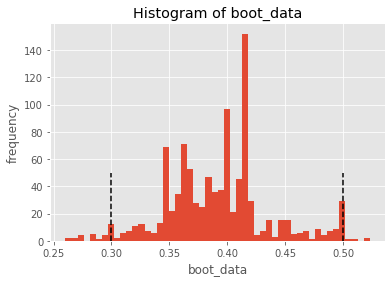

{'ci':          0
 0.025  0.3
 0.975  0.5,
 'p_value': 1.3330419955623996e-18}

In [192]:
get_bootstrap(rent['Игрок 1'].dropna(), rent['Игрок 2'].dropna(), statistic = np.median)

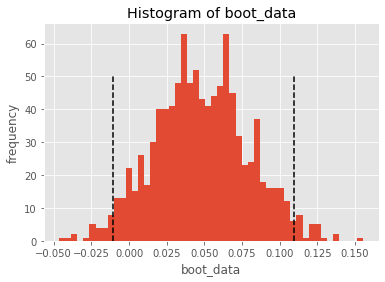

{'ci':               0
 0.025 -0.010587
 0.975  0.109686,
 'p_value': 0.12153508337655834}

In [153]:
get_bootstrap(rent['Игрок 1'].dropna(), rent['Игрок 2'].dropna(), statistic = np.mean)

### Среднее количество продаж

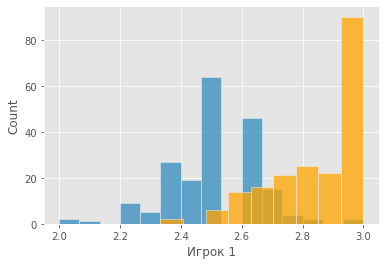

In [159]:
sns.histplot(sales['Игрок 1'])
sns.histplot(sales['Игрок 2'], color = 'orange')

In [166]:
mannwhitneyu(sales['Игрок 1'].dropna().sample(100), sales['Игрок 2'].dropna().sample(100))

MannwhitneyuResult(statistic=618.0, pvalue=2.9764762965476446e-27)

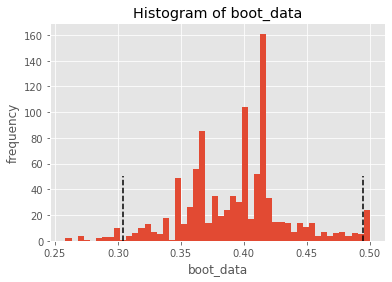

{'ci':               0
 0.025  0.304432
 0.975  0.494444,
 'p_value': 6.890233266253611e-21}

In [193]:
get_bootstrap(sales['Игрок 1'].dropna(), sales['Игрок 2'].dropna(), statistic = np.median)

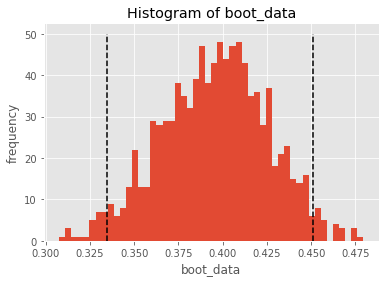

{'ci':               0
 0.025  0.334734
 0.975  0.450977,
 'p_value': 4.363312595894404e-40}

In [194]:
get_bootstrap(sales['Игрок 1'].dropna(), sales['Игрок 2'].dropna(), statistic = np.mean)

### Сравнение аренды в сегменте SMB

In [185]:
SMB = fin.query('Segment == "SMB" ')[['avg_deals_per_region', 'Company']].pivot(columns = 'Company', values = 'avg_deals_per_region')

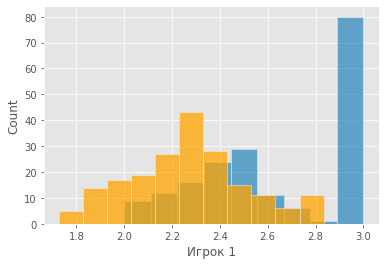

In [186]:
sns.histplot(SMB['Игрок 1'])
sns.histplot(SMB['Игрок 2'], color = 'orange')

In [187]:
mannwhitneyu(SMB['Игрок 1'].dropna().sample(100), SMB['Игрок 2'].dropna().sample(100))

MannwhitneyuResult(statistic=8089.0, pvalue=2.9568084999243146e-14)

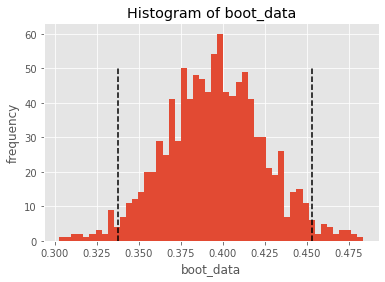

{'ci':              0
 0.025  0.33781
 0.975  0.45286,
 'p_value': 8.749937943155961e-42}

In [188]:
get_bootstrap(SMB['Игрок 1'].dropna(), SMB['Игрок 2'].dropna(), statistic = np.mean)

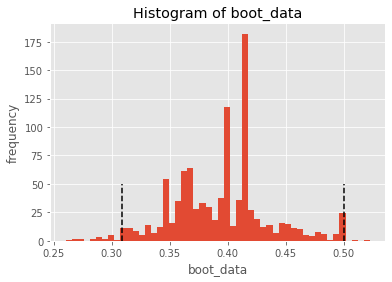

{'ci':               0
 0.025  0.309091
 0.975  0.500000,
 'p_value': 5.940645237892565e-21}

In [189]:
get_bootstrap(SMB['Игрок 1'].dropna(), SMB['Игрок 2'].dropna(), statistic = np.median)